In [23]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

Используем датасет PASCAL Visual Object Classes (PASCAL VOC) и свою имплементацию U-Net

In [2]:
def convert_color(color):
    if color == 255:
        return 2
    if color == 0:
        return 0
    return 1

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    for y in input_mask:
        for x in y:
            x[0] = convert_color(x[0])
    return input_image, input_mask

In [46]:
def load_data(file, augmentation):
    with open(file, 'r') as img_list:
        images = []
        masks = []
        for line in img_list:
            line = line.strip()
            if len(line) == 0:
                continue
            else:
                img = tf.keras.utils.load_img(path=f'VOC2011/JPEGImages/{line}.jpg', target_size=(128, 128))
                img = tf.keras.utils.img_to_array(img)
                mask = tf.keras.utils.load_img(path=f'VOC2011/SegmentationClass/{line}.png', color_mode='grayscale', target_size=(128, 128))
                mask = tf.keras.utils.img_to_array(mask)
                img, mask = normalize(img, mask)
#                 if augmentation:
#                     img_flipped = tf.image.flip_left_right(img)
#                     mask_flipped = tf.image.flip_left_right(mask)
#                     images.append(img_flipped)
#                     masks.append(mask_flipped)
                images.append(img)
                masks.append(mask)
                
        return tf.data.Dataset.from_tensor_slices((images, masks))
                

In [37]:
# ds_train = load_data('VOC2011/ImageSets/Segmentation/train.txt', True)
# ds_test = load_data('VOC2011/ImageSets/Segmentation/val.txt', False)

In [38]:
# ds_train.save('pascal_voc_train')
# ds_test.save('pascal_voc_test')

In [39]:
# train = tf.data.Dataset.load('pascal_voc_train')
# test = tf.data.Dataset.load('pascal_voc_test')

In [47]:
ds = load_data('VOC2011/ImageSets/Segmentation/trainval.txt', False)

In [48]:
train, test = tf.keras.utils.split_dataset(ds, left_size=0.8)

In [49]:
TRAIN_LENGTH = len(train)
BATCH_SIZE = 16
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [50]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [7]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

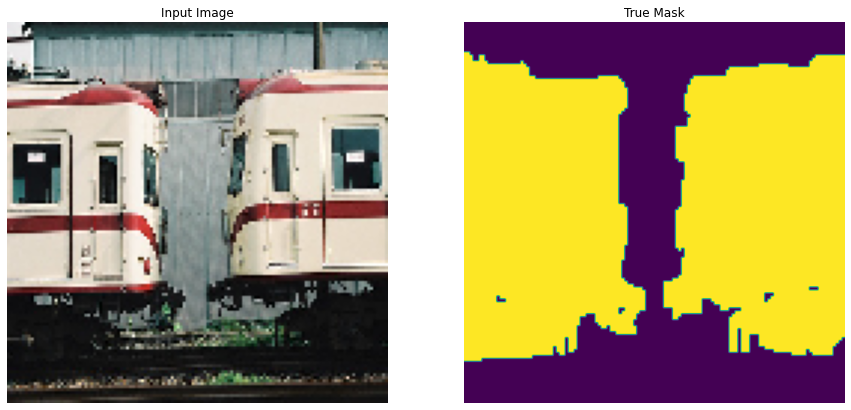

In [52]:
for image, mask in train.take(4):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [9]:
def encoder_block(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
 
    conv = Conv2D(n_filters, 
                  kernel_size=(3, 3),    
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters, 
                  kernel_size=(3, 3), 
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
    
    conv = BatchNormalization()(conv, training=False)

    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)
    
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))(conv)    
    else:
        next_layer = conv
 
    skip_connection = conv
    
    return next_layer, skip_connection

In [10]:
def decoder_block(prev_layer_input, skip_layer_input, n_filters=32):

    up = Conv2DTranspose(
                 n_filters,
                 kernel_size=(3, 3), 
                 strides=(2, 2),
                 padding='same')(prev_layer_input)

    merge = concatenate([up, skip_layer_input], axis=3)

    conv = Conv2D(n_filters, 
                 kernel_size=(3, 3), 
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 kernel_size=(3, 3), 
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

In [29]:
def get_unet_model(input_size=(128, 128, 3), n_filters=32, n_classes=3):

    inputs = Input(input_size)
      
    cblock1 = encoder_block(inputs, n_filters, dropout_prob=0, max_pooling=True)
    cblock2 = encoder_block(cblock1[0], n_filters*2, dropout_prob=0.1, max_pooling=True)
    cblock3 = encoder_block(cblock2[0], n_filters*4, dropout_prob=0.25, max_pooling=True)
    cblock4 = encoder_block(cblock3[0], n_filters*8, dropout_prob=0.25, max_pooling=True)
    cblock5 = encoder_block(cblock4[0], n_filters*16, dropout_prob=0.25, max_pooling=False) 
    
    ublock6 = decoder_block(cblock5[0], cblock4[1], n_filters*8)
    ublock7 = decoder_block(ublock6, cblock3[1], n_filters*4)
    ublock8 = decoder_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = decoder_block(ublock8, cblock1[1], n_filters)

    conv9 = Conv2D(n_filters,
                 kernel_size=(3, 3),
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [32]:
model = get_unet_model(input_size=(128,128,3), n_filters=32, n_classes=3)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [53]:
# model.summary()
# tf.keras.utils.plot_model(model, show_shapes=True)

In [18]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [55]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask, 
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 82ms/step


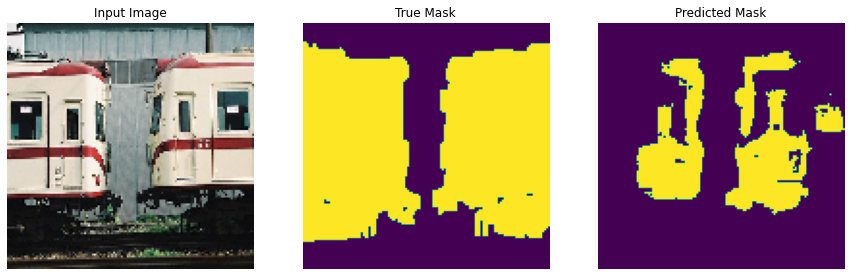

In [56]:
show_predictions()

In [24]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 29ms/step


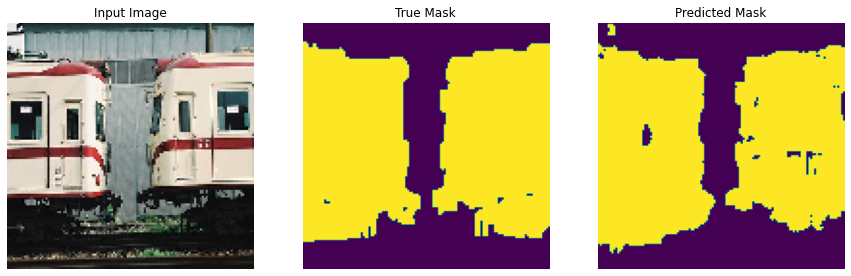


Sample Prediction after epoch 20

111/111 [==============================] - 44s 398ms/step - loss: 0.0987 - accuracy: 0.9607 - val_loss: 0.1301 - val_accuracy: 0.9518


In [57]:
EPOCHS = 20 
VAL_SUBSPLITS = 5
VALIDATION_STEPS = len(test)//BATCH_SIZE//VAL_SUBSPLITS

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), stop_early])

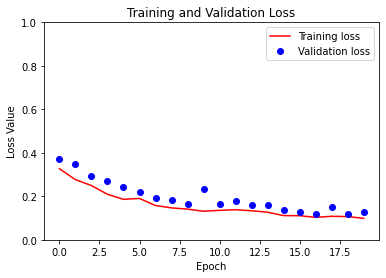

In [58]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

1/1 [==============================] - 0s 31ms/step


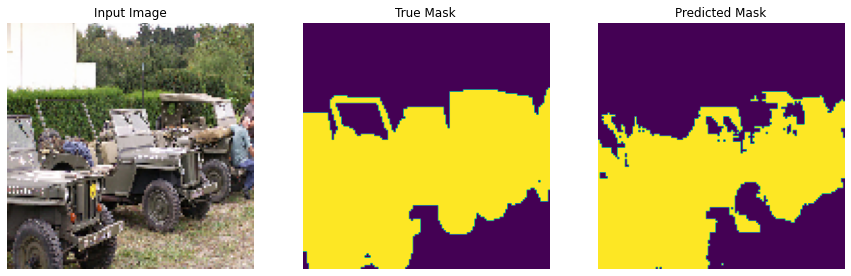

1/1 [==============================] - 0s 32ms/step


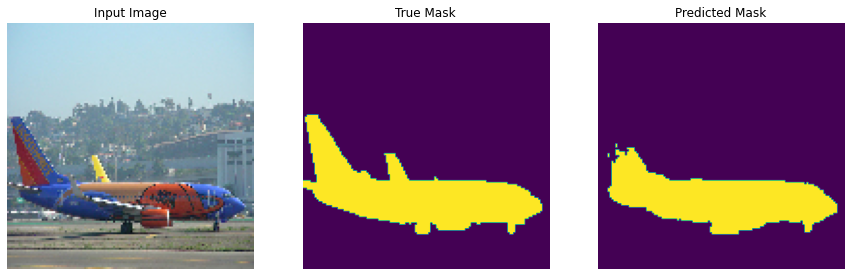

1/1 [==============================] - 0s 33ms/step


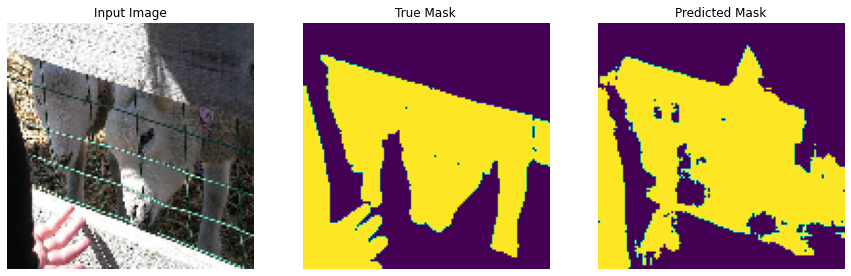

1/1 [==============================] - 0s 33ms/step


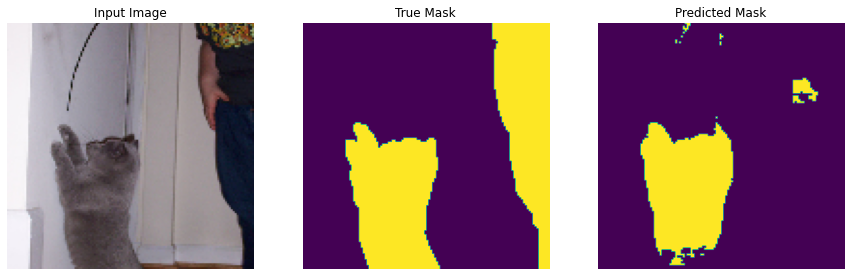

1/1 [==============================] - 0s 33ms/step


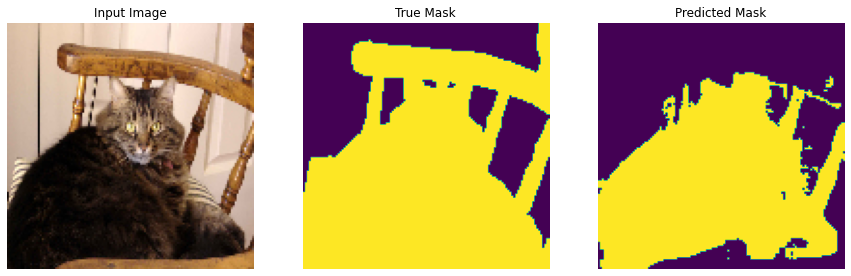

In [59]:
show_predictions(test_dataset, 5)

1. Для борьбы с переобучением применяем dropout на каждом сверточном слое.
2. Поскольку доступа к тестовым данным нет, для тренировки и валидации используется часть датасета, к которой существуют готовые маски. Разбиение на тренинговый и валидационный датасет 0.8/0.2
3. Используем довольно маленький batch_size и количество эпох 20.